In [ ]:
import sys
sys.path.append('~/MedorionDsTools')

# import file1

In [132]:
import MedorionDsTools.BigqueryUtils
import MedorionDsTools.Feateng
import MedorionDsTools.zips_data_call
import MedorionDsTools.Preprocessing
import MedorionDsTools.Modeling
import MedorionDsTools.Explain
import MedorionDsTools.Visual
import MedorionDsTools.CustumersData
import MedorionDsTools.ActionDrivenInsight
from pandas import read_parquet,DataFrame
import importlib
import base64
from IPython.display import Image, display, HTML
import matplotlib.pyplot as plt
from pandas import concat, Series, DataFrame
import numpy as np
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier









importlib.reload(MedorionDsTools.Feateng)
importlib.reload(MedorionDsTools.BigqueryUtils)
importlib.reload(MedorionDsTools.zips_data_call)
importlib.reload(MedorionDsTools.Preprocessing)
importlib.reload(MedorionDsTools.Modeling)
importlib.reload(MedorionDsTools.Explain)
importlib.reload(MedorionDsTools.Visual)
importlib.reload(MedorionDsTools.CustumersData)
importlib.reload(MedorionDsTools.ActionDrivenInsight)



def mm(graph, width=200, height=300):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(
        HTML(
            f'<div style="text-align:center"><img src="https://mermaid.ink/img/{base64_string}" width="{width}" height="{height}"></div>'
        )
  )




## Introduction to Uplift Modeling

Our goal is to measure the causal impact of a specific intervention (such as providing a transportation subsidy) on a target outcome of interest (such as adhering to a prescribed statin medication). To do this, we need to estimate the uplift, which is the difference in the outcome between the unit $i$ with treatment versus without. However, not all units are equally affected by the intervention. Some may benefit more, some may benefit less, and some may even be harmed by it. Therefore, we need to identify the heterogeneous treatment effects, which capture how the intervention affects different subgroups of units in different ways.


### confounding variables and backdoor


A confounding variable is a variable that affects both the independent variable and the dependent variable in a causal study, and thus creates a spurious association between them. A confounding variable opens a backdoor path from the independent variable to the dependent variable, which is a non-causal path that allows information to flow between them. This backdoor path confounds or biases the estimation of the causal effect of the independent variable on the dependent variable.



In [126]:

mm("""
flowchart TD
   Mem["Member Data(X)"] --> Treatment["Treatment(T)"]  
   Treatment --> outcome["outcome(Y)"]
   Mem --> outcome

""")



 To close the backdoor path, we need to control for the confounding variable by conditioning on it.


$$\text{uplift}(x_{i}) = E[Y_i(\text{intervention}) − Y_i(\text{no intervention})|X=x_{i}] $$




###  Modeling Uplift

One way to estimate the uplift is to use the two-model approach, which involves building two separate predictive models: one for the treatment group and one for the control group. Each model predicts the outcome of interest for a given unit based on its features. Then, we can combine the two models into one uplift model by subtracting the predictions of the treatment model from the predictions of the control model. This way, we can obtain the expected difference in the outcome between the treated and untreated versions for each unit. The advantage of this approach is that it is simple and intuitive, and it can use any existing supervised learning algorithm. 


In [131]:


mm("""
flowchart TD
    mem["Members"]-->mem_tr["Treatment Group"]
    mem["Members"]-->mem_ct["Ctrl Group"]
    mem_ct["Ctrl Group"]-->|70%|train["Train data"]
    mem_tr["Treatment Group"]-->|70%|train["Train data"]
    mem_ct["Ctrl Group"]-->|30%|test["Test data"]
    mem_tr["Treatment Group"]-->|30%|test["Test data"]
    train-->uplift["Uplift Modeling"]
    uplift-->|predict|test
    test-->seg["uplift segmentation"]

""",
width=350
,height=500)

### uplift Segtments

- The Persuadables: These are the members who only respond to the campaign because they were targeted. They are the ideal segment for the campaign, as they generate positive uplift. For example, a persuadable customer might imporove his adhernce to statins after receiving a transportation benfit.
- The Sure Things: These are the members who would be adherent regardless of whether they were targeted or not. They do not generate any uplift, as they would have been adherent  anyway. 
- The Lost Causes: These are the members who would not change no matter what. They also do not generate any uplift, as they are not adherent.
- The Sleeping Dogs: These are the members who generate negative uplift.



## Does transportaion benefit cause to adherence with statins
## load data

In [31]:
df = read_parquet("~/df_feats.parquet")



## Preprocessing

In [ ]:

categorical_features = ['gender','race']
df = MedorionDsTools.Preprocessing.categorical_encoding(df,categorical_features)

numerical_features = MedorionDsTools.Preprocessing.numerical_features

<!-- ## Add labels -->



<!-- ## Choose the features to be used in the model

    + In order to build a model there is a need to transfer categorial features to dummy features 
    + you can see the categorial features with the code

```python

MedorionDsTools.Preprocessing.print_features(df)

```  -->

<!-- ## Preprocessing  the features before modeling -->

<!-- + print all the featuress in the dataframe in order  to select which features to include in the model 
+ insert your selection to  lists  -->

## Modeling the uplift score


In [ ]:
intervention_object =  MedorionDsTools.ActionDrivenInsight.creat_action_uplift_df(df, intervention_col = 'has_transportation_benefit',label_for_modeling = "adherence_statins",numerical_features = numerical_features)

uplift_df = MedorionDsTools.ActionDrivenInsight.creat_uplift(intervention_object)

## Segmentation 

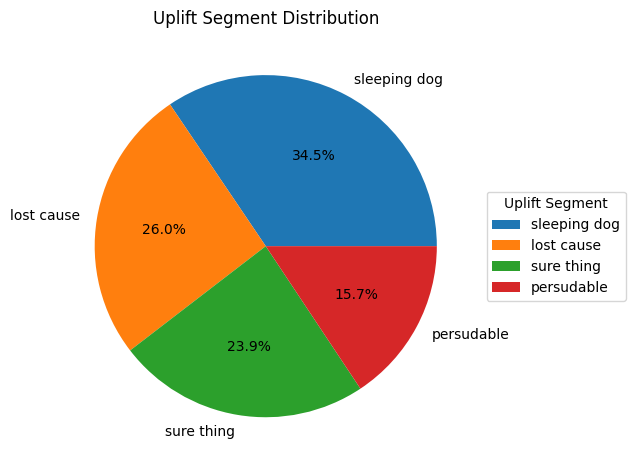

<Figure size 640x480 with 0 Axes>

In [153]:
MedorionDsTools.Visual.distribution_plot(pd_series=uplift_df.uplift_segment,title='Uplift Segment Distribution',legend_title='Uplift Segment')

## Analysis of the uplift segments

In [161]:
uplift_df_insight = concat([uplift_df.reset_index(drop=True),intervention_object["X"].reset_index(drop=True)],axis=1)


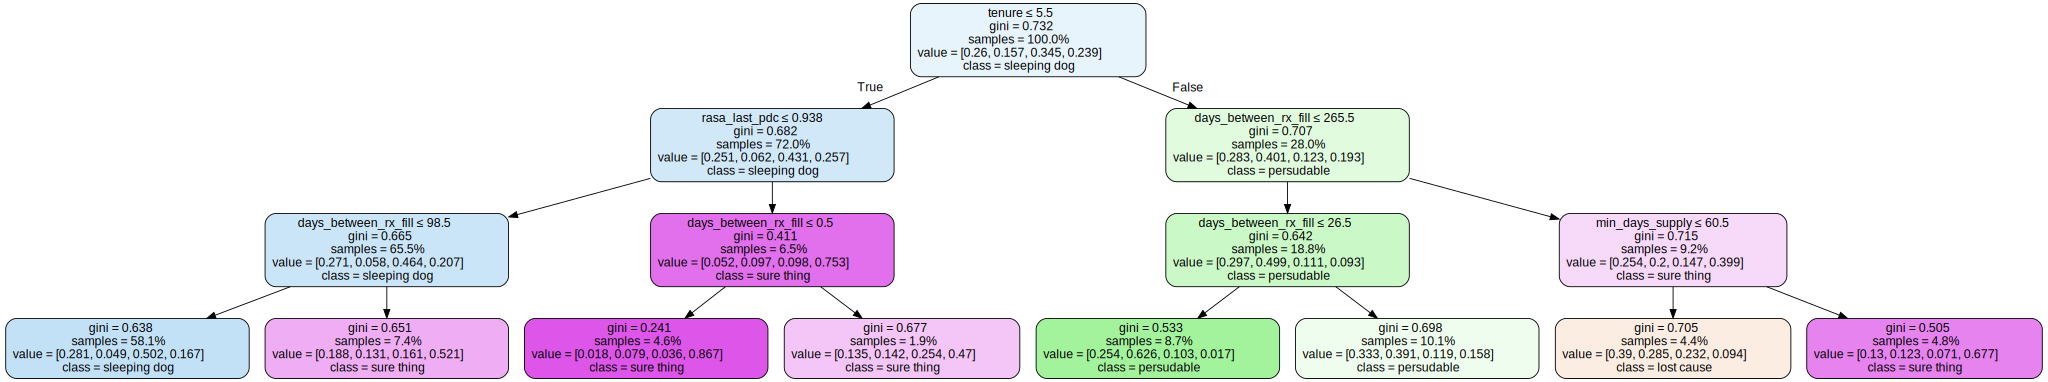

In [188]:
MedorionDsTools.Visual.plot_tree(df = uplift_df_insight,numerical_features=numerical_features)